# 라이브러리 불러오기

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
train= pd.read_csv("/content/drive/Shareddrives/22-1 KUBIG 장기프로젝트/최종프로젝트/train_서울대공원_혼잡도예측_프로젝트.csv")
test=pd.read_csv("/content/drive/Shareddrives/22-1 KUBIG 장기프로젝트/최종프로젝트/test_서울대공원_혼잡도예측_프로젝트.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



# K-MEANS

이용자 수 분류 목적

In [ ]:
train_y=train[['입장객 수']]
#임시휴원 있는 행 삭제
spac=train_y[train_y['입장객 수']=='임시휴원'].index
train_y.drop(spac,inplace=True)

train_y = train_y.astype({'입장객 수':'float64'})      

#변수명 영어로
train_y=train_y.rename(columns={"입장객 수":"Attendance"})

from sklearn.cluster import KMeans

#k-means#################################################
k = 3

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(train_y)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
train_y['cluster'] = model.fit_predict(train_y)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
train_y.loc[train_y['cluster'] == 0, 'cluster'] = 'slack' #여유
train_y.loc[train_y['cluster'] == 1, 'cluster'] = 'normal' #보통
train_y.loc[train_y['cluster'] == 2, 'cluster'] = 'crowded'  #혼잡

cluster0=train_y[train_y['cluster']=='slack']['Attendance']
cluster1=train_y[train_y['cluster']=='normal']['Attendance']
cluster2=train_y[train_y['cluster']=='crowded']['Attendance']

print(f'한산은 {cluster0.max()} 이하, 보통은 {cluster0.max()} 초과 {cluster1.max()} 이하, 혼잡은 {cluster1.max()} 초과')

한산은 9312.0 이하, 보통은 9312.0 초과 23117.0 이하, 혼잡은 23117.0 초과


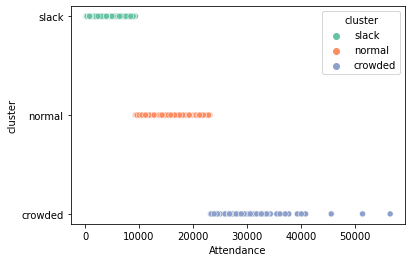

In [ ]:
sns.scatterplot(x='Attendance',y="cluster",hue="cluster", data=train_y, palette="Set2")

# train+test 데이터 통합

같이 전처리 후 분할 예정

ntrain/ntest 저장을 위해 행 삭제하는 전처리 미리 진행

In [ ]:

#임시휴원 있는 행 삭제
spac=train[train['입장객 수']=='임시휴원'].index
train.drop(spac,inplace=True)

#test data의 y값 '정보없음' 행 삭제
test=test.drop([249])

all_data = pd.concat((train, test)).reset_index(drop=True)

ntrain = train.shape[0]
ntest = test.shape[0]


# 데이터 정제

In [ ]:
#날짜 분리하여 새로운 변수 만들기
all_data[['년','월','일']] = all_data['날짜'].str.split('-', expand=True)
all_data.drop(['날짜'], axis=1, inplace=True)


#임시휴원 있는 행 삭제
spac=all_data[all_data['입장객 수']=='임시휴원'].index
all_data.drop(spac,inplace=True)


#미세먼지 농도 - -> NAN값 처리
all_data['미세먼지 농도']=all_data['미세먼지 농도'].replace('-', np.NaN)

#공휴일 여부 -> 0,1로 변환
all_data['공휴일여부']=all_data['공휴일여부'].replace(np.NaN, 0)
all_data['공휴일여부']=all_data['공휴일여부'].replace('공휴일', 1)

#'쉬는날여부' 제거, '주말여부' 파생변수 생성
all_data.drop('쉬는날여부', axis = 1, inplace = True)
all_data['주말여부'] = np.where((all_data['요일'] == '토') | (all_data['요일'] == '일'), 1, 0)

In [ ]:
#변수 영어로 바꾸기
all_data.columns = ['Day','Season','Pub_holiday','Vacation','Precipitation_accum','Humidity_avg','Attendance','Get_off_subway','Fine_dust_concentration',
                 'L_Temperature','H_Temperature','A_Temperature','Year','Month','Date','Weekend']

#변수 영어로 바꾸기2
all_data = all_data.replace({'Day' : '월'},'Mon')
all_data = all_data.replace({'Day' : '화'},'Tue')
all_data = all_data.replace({'Day' : '수'},'Wed')
all_data = all_data.replace({'Day' : '목'},'Thu')
all_data = all_data.replace({'Day' : '금'},'Fri')
all_data = all_data.replace({'Day' : '토'},'Sat')
all_data = all_data.replace({'Day' : '일'},'Sun')

all_data = all_data.replace({'Season' : '봄'},'Spring')
all_data = all_data.replace({'Season' : '여름'},'Summer')
all_data = all_data.replace({'Season' : '가을'},'fall')
all_data = all_data.replace({'Season' : '겨울'},'Winter')   

# EDA

In [ ]:
train = all_data[:ntrain]
#데이터 타입 바꾸기
train = train.astype({'Year':'int'})
train = train.astype({'Month':'int'})
train = train.astype({'Date':'int'})
train = train.astype({'Fine_dust_concentration':'float64'})
train = train.astype({'Attendance':'float64'})    
#변수정렬
train=train[['Year','Month','Date','Day','Season','Pub_holiday','Vacation','Precipitation_accum','Humidity_avg','Attendance','Get_off_subway','Fine_dust_concentration',
                 'L_Temperature','H_Temperature','A_Temperature','Weekend']]

In [ ]:
print(train.shape); print(test.shape) 

(994, 16)
(364, 14)


입장객과 대공원역 하차자수의 분포 비교

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


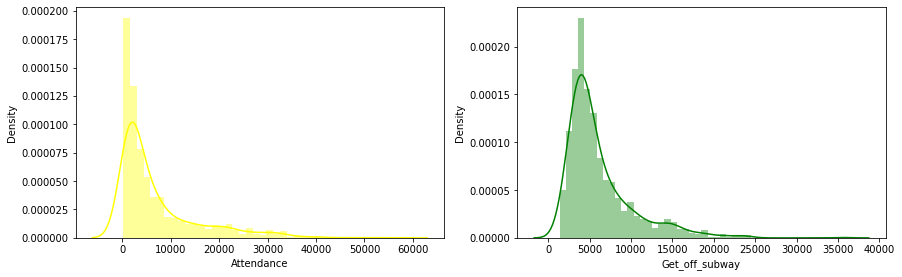

In [ ]:
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.subplot(121)
sns.distplot(train["Attendance"], color="yellow")
plt.subplot(122)
sns.distplot(train["Get_off_subway"], color="green")
plt.show()

In [ ]:
#y의 요약통계량
train['Attendance'].describe()

count      994.000000
mean      6948.727364
std       8413.125054
min        128.000000
25%       1430.000000
50%       3339.000000
75%       8543.500000
max      56576.000000
Name: Attendance, dtype: float64

Q3~MAX 사이의 일부 입장객 수 정보

In [ ]:
train[train['Attendance']>8543.5]
#공휴일과 주말에 입장객이 엄청 많다.

,Year,Month,Date,Day,Season,Pub_holiday,Vacation,Precipitation_accum,Humidity_avg,Attendance,Get_off_subway,Fine_dust_concentration,L_Temperature,H_Temperature,A_Temperature,Weekend
40,2016,2,10,Wed,Winter,1,0,0.0,45.041667,9949.0,7664.0,41.0,-1.5,9.100000,2.929167,0
65,2016,3,6,Sun,Spring,0,0,0.0,50.875000,11564.0,6197.0,89.0,4.5,12.400000,7.741667,1
67,2016,3,8,Tue,Spring,0,0,0.0,40.791667,11521.0,2997.0,76.0,-1.8,5.000000,1.691667,0
78,2016,3,19,Sat,Spring,0,0,0.0,61.583333,33131.0,15698.0,76.0,3.0,16.200001,9.795833,1
79,2016,3,20,Sun,Spring,0,0,0.0,55.250000,34360.0,12699.0,81.0,3.3,16.000000,9.591667,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,2018,10,21,Sun,fall,0,0,0.0,63.750000,21054.0,9972.0,38.0,5.1,20.200001,11.070833,1
927,2018,10,26,Fri,fall,0,0,11.0,65.000000,14283.0,9486.0,32.0,7.8,14.300000,11.254167,0
928,2018,10,27,Sat,fall,0,0,4.0,57.208333,21256.0,13015.0,27.0,2.6,11.800000,7.579167,1
935,2018,11,3,Sat,fall,0,0,0.0,66.875000,16625.0,11957.0,52.0,2.0,19.299999,8.954167,1


요일별 입장객수 비교

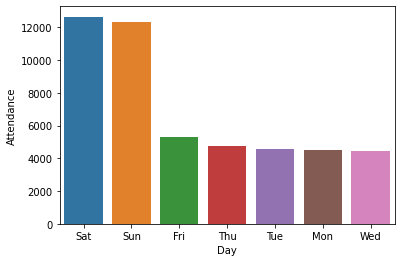

In [ ]:
train_groupby = train.groupby(by='Day')
train_groupby_mean=train_groupby.mean().sort_values(by=['Attendance'],ascending=False)
sns.barplot(x=train_groupby_mean.index ,y='Attendance',data=train_groupby_mean)

#Q. 어떤 요일에 서울대공원을 방문하면 좋을까?
#주말과 금요일에 사람들이 가장 많이 방문(나머지는 대동소이)

요일별 공휴일의 수 비교

In [ ]:
train_public_holiday=train[train['Pub_holiday']==1]
#공휴일에 방문자가 많을텐데, 요일의 관계를 알고싶으면 공휴일 역시 고려해야되지 않을까?-> 공휴일이 월화수목에 많다
#Attendance의 평균이 6948임을 고려할때, 요일에 상관없이 모든 공휴일의 방문객 수의 평균이 이를 넘었다. 즉 공휴일(주말x)에 평소보다 사람이 더 많이 옴을 확인 
#종합적으로 고려해보았을때 평상시에는 금토일에 더 많은 비율의 사람이 몰릴 것이라 예상(밑에서 알 수 있듯이 주말을 제외한 공휴일에 주말보다 많은 방문객을 확인
#즉 공휴일이 아닌 평일에는 훨씬 더 적은 방문객임을 알 수 있다) 
print(train_public_holiday['Day'].value_counts())
train_public_holiday.groupby(by='Day').mean().sort_values(by=['Attendance'],ascending=False)

Tue    9
Mon    8
Wed    7
Thu    5
Fri    4
Sat    3
Sun    2
Name: Day, dtype: int64


,Year,Month,Date,Pub_holiday,Vacation,Precipitation_accum,Humidity_avg,Attendance,Get_off_subway,Fine_dust_concentration,L_Temperature,H_Temperature,A_Temperature,Weekend
Day,,,,,,,,,,,,,,
Sat,2017.333333,4.000000,12.000000,1.0,0.000000,6.166667,46.194444,29298.333333,16958.000000,44.333333,7.566667,16.600000,11.669444,1.0
Thu,2017.000000,5.800000,8.200000,1.0,0.000000,0.080000,54.725000,22122.400000,13415.600000,37.250000,7.260000,15.740000,11.182500,0.0
Fri,2016.750000,4.250000,9.500000,1.0,0.250000,4.275000,57.708333,21094.250000,10860.250000,54.750000,4.900000,15.075000,10.586458,0.0
Wed,2017.142857,7.142857,7.857143,1.0,0.142857,0.014286,60.136905,18081.000000,10960.428571,39.857143,13.000000,24.914286,18.418452,0.0
Sun,2017.000000,9.500000,16.000000,1.0,0.000000,0.000000,54.395833,17262.000000,8141.500000,24.000000,9.050000,20.950000,14.983333,1.0
Tue,2017.222222,7.222222,12.777778,1.0,0.222222,12.766667,67.611111,14953.777778,9163.777778,28.666667,7.955556,15.444444,11.221759,0.0
Mon,2016.750000,7.250000,11.375000,1.0,0.375000,0.012500,63.609375,14364.375000,8269.125000,32.000000,8.600000,17.737500,12.948438,0.0


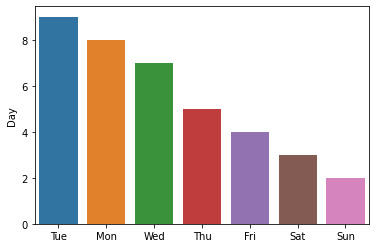

In [ ]:
ds=pd.DataFrame(train_public_holiday['Day'].value_counts())
sns.barplot(x=ds.index ,y=ds['Day'],data=ds)

입장객 수 비교: 공휴일(주말 제외) vs 주말 vs 평일(공휴일 제외)

12489.982456140351
17304.696969696968
4107.004437869822


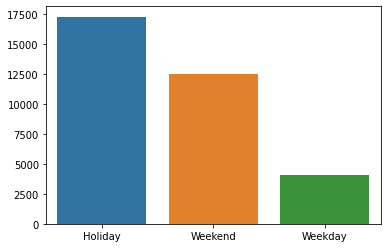

In [ ]:
#그렇다면 공휴일(주말 제외) vs 주말 vs 평일(공휴일 제외) 의 방문객수의 평균 중 어떤 때가 더 많을까?
train_weekend= train.loc[(train['Day'] == 'Sat') | (train['Day'] == 'Sun'),['Attendance','Day']]
print(train_weekend['Attendance'].mean()) #주말 평균 12489
a=train_weekend['Attendance'].mean()
#공휴일(주말제외)
train_pubholi=train.loc[(train['Pub_holiday'] == 1) & (train['Day'] != 'Sat')& (train['Day'] != 'Sun'),['Attendance','Day']]
print(train_pubholi['Attendance'].mean()) #17304 #예상외로 주말을 제외한 공휴일에 주말보다 방문객이 더 많았다(어린이날 등의 영향일듯)
b=train_pubholi['Attendance'].mean()

#평일(공휴일제외)
train_day=train.loc[(train['Pub_holiday'] == 0) & (train['Day'] != 'Sat')& (train['Day'] != 'Sun'),['Attendance','Day']]
print(train_day['Attendance'].mean())  #4107 예상대로 가장 적음
c=train_day['Attendance'].mean()

sns.barplot(x=['Holiday','Weekend','Weekday'] ,y=[b,a,c])

계절별/방학별 입장객 수는?

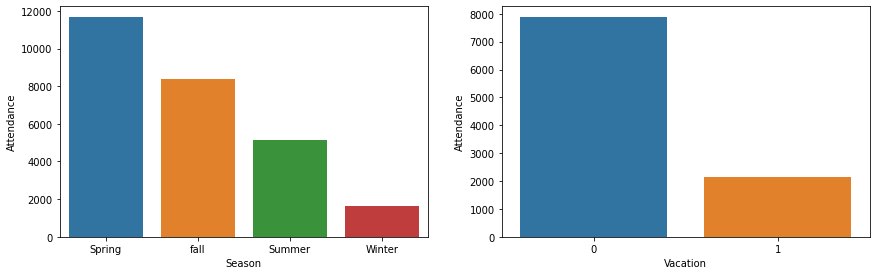

In [ ]:
train_groupby = train.groupby(by='Season')
train_groupby_mean=train_groupby.mean().sort_values(by=['Attendance'],ascending=False)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.subplot(121)
sns.barplot(x=train_groupby_mean.index ,y='Attendance',data=train_groupby_mean)
#봄-가을-여름-겨울 순

train_groupby1 = train.groupby(by='Vacation')
train_groupby1_mean=train_groupby1.mean().sort_values(by=['Attendance'],ascending=False)

plt.subplot(122)
sns.barplot(x=train_groupby1_mean.index ,y='Attendance',data=train_groupby1_mean)
#(여름/겨울)방학이 아닐때 오히려 더 많은 방문객 수

## 학생들의 방학이 방문객 수에 큰 영향을 끼치지 않은 것으로 파악(중고등학생들의 방문이 적음을 유추)->실제 데이터에서 어린이/청소년의 방문이 예상외로 적다.

년별/달별 입장객 수

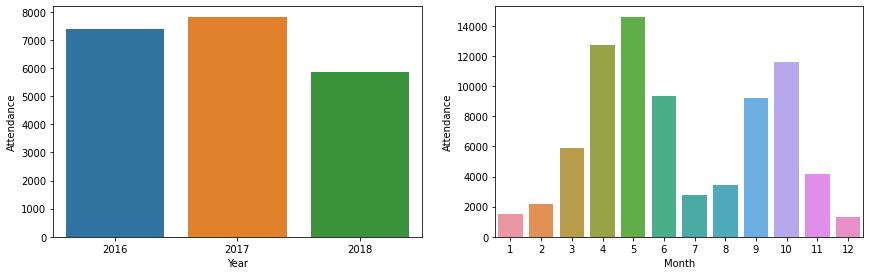

In [ ]:
train_groupby = train.groupby(by='Year')
train_groupby_mean=train_groupby.mean().sort_values(by=['Attendance'],ascending=False)

plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.subplot(121)
sns.barplot(x=train_groupby_mean.index ,y='Attendance',data=train_groupby_mean)
#년도별 비교는 큰 의미 없을듯

train_groupby1 = train.groupby(by='Month')
train_groupby1_mean=train_groupby1.mean().sort_values(by=['Attendance'],ascending=False)

plt.subplot(122)
sns.barplot(x=train_groupby1_mean.index ,y='Attendance',data=train_groupby1_mean)

#4,5,10월이 높음-> 봄,가을-> 선선한 날씨의 영향일듯


절기별 운영시간의 차이 분석

10188.112759643916
7526.723577235773
2417.6388888888887


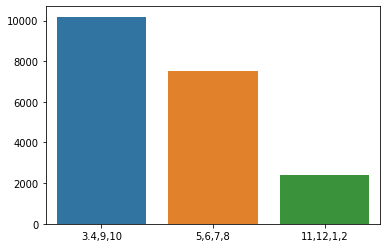

In [ ]:
train_1=train.loc[(train['Month'] == 3) | (train['Month'] == 4)| (train['Month'] == 9)| (train['Month'] == 10),['Attendance','Day']]
train_2=train.loc[(train['Month'] == 5) | (train['Month'] == 8)| (train['Month'] == 6)| (train['Month'] == 7),['Attendance','Day']]
train_3=train.loc[(train['Month'] == 11) | (train['Month'] == 12)| (train['Month'] == 1)| (train['Month'] == 2),['Attendance','Day']]
 
print(train_1['Attendance'].mean()) #간절기
a=train_1['Attendance'].mean()
print(train_2['Attendance'].mean()) #하절기
b=train_2['Attendance'].mean()
print(train_3['Attendance'].mean()) #동절기
c= train_3['Attendance'].mean()

sns.barplot(x=['3.4,9,10','5,6,7,8','11,12,1,2'] ,y=[a,b,c])

수치형 변수 단변수 분포 확인

<Figure size 432x288 with 0 Axes>

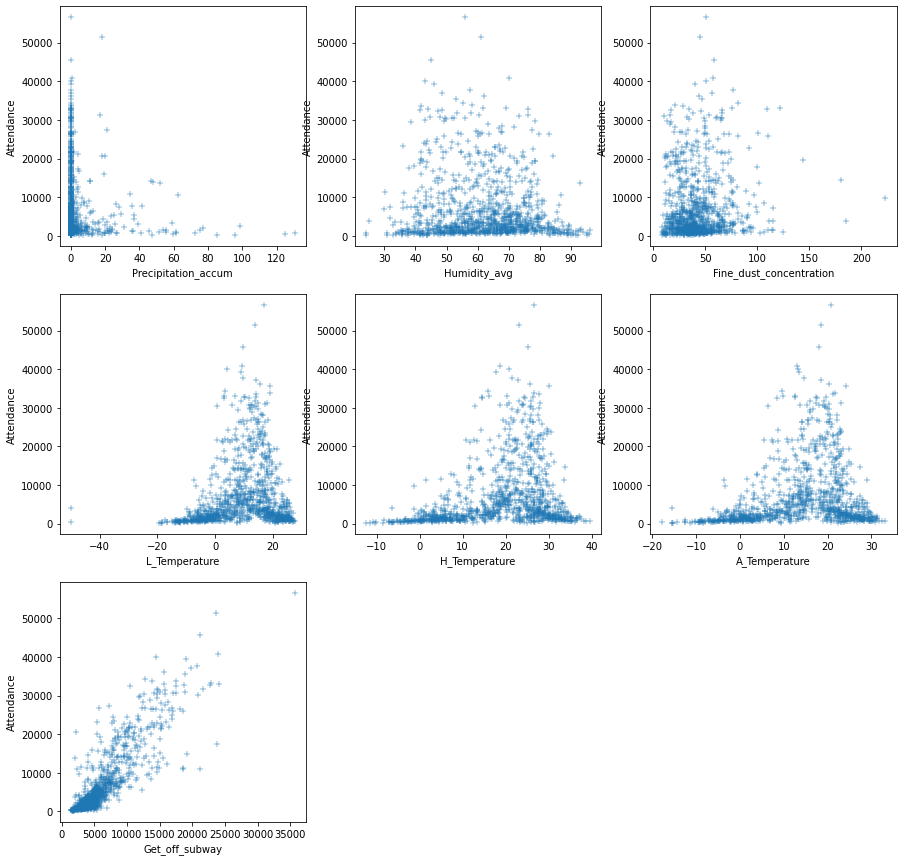

In [ ]:
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=2, 
                    top=0.9, 
                    wspace=0.2, 
                    hspace=0.35)
plt.figure(figsize=(15,15))
plt.subplot(331)
sns.scatterplot(x='Precipitation_accum', y= 'Attendance', data= train,marker='+',ci=99)  #강수량이 늘어날수록 입장객 감소(강수량의 영향)
plt.subplot(332)
sns.scatterplot(x='Humidity_avg', y= 'Attendance', data= train,marker='+',ci=99) #습도가 높아질수록 입장객의 감소하나 그 영향이 미비함
plt.subplot(333) 
sns.scatterplot(x='Fine_dust_concentration', y= 'Attendance', data= train,marker='+',ci=99) #미세먼지 31~80 정도가 보통인데 아무래도 미세먼지가 높으면 입장객 감소
plt.subplot(334)
sns.scatterplot(x='L_Temperature', y= 'Attendance', data= train, marker='+',ci=99) #
plt.subplot(335)
sns.scatterplot(x='H_Temperature', y= 'Attendance', data= train, marker='+',ci=99) #
plt.subplot(336)
sns.scatterplot(x='A_Temperature', y= 'Attendance', data= train, marker='+',ci=99) #최저,최고,평균 기온보다 볼록한 분포->일정 온도 이상 입장객 증가했다가 그 후 다시 감소
plt.subplot(337)
sns.scatterplot(x='Get_off_subway', y= 'Attendance', data= train, marker='+',ci=99) #대공원역 하차자 수와는 명확한 양의 상관

히트맵 확인

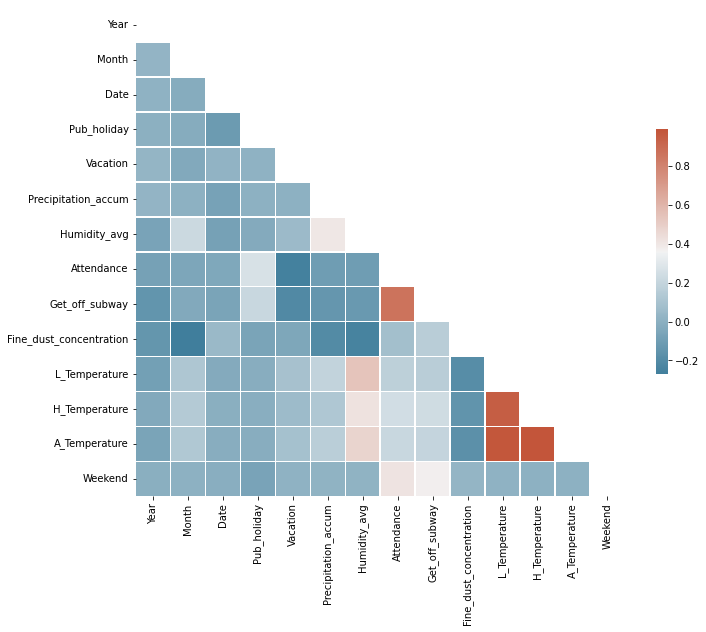

In [ ]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(train.corr()))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(train.corr(), mask=mask, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.yticks(rotation=0)
plt.show()

#Attendance 쪽을 보면 모든 수치형변수들이 양의 관계를 가지지만 '하차자수'를 제외하면 그 영향이 그리 크지 않음

피어슨 상관분석(대공원역 하차자 수vs 입장객수)

In [ ]:
import scipy.stats as stats
rho, p_val = stats.pearsonr(train['Attendance'], train['Get_off_subway'])
print("correlation coefficient : {}, p-value : {}".format(rho,p_val))

#귀무가설 기각(상관계수=0)-> 대공원역 하차자수와 입장객 사이의 높은 양의 상관을 검증할 수 있다. 즉 대공원역 하차자가 많을수록 입장객이 증가한다

correlation coefficient : 0.868898425844079, p-value : 3.19515523031619e-305


Factor analysis

In [ ]:
train=train.dropna(axis=0)

In [ ]:
train_num=train[['Precipitation_accum','Humidity_avg','Get_off_subway','Fine_dust_concentration','L_Temperature','H_Temperature','A_Temperature']]
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_std = pd.DataFrame(scaler.fit_transform(train_num), columns=train_num.columns, index=train_num.index) 

array([0.48897834, 0.2100101 , 0.119117  , 0.10686878, 0.06943051])

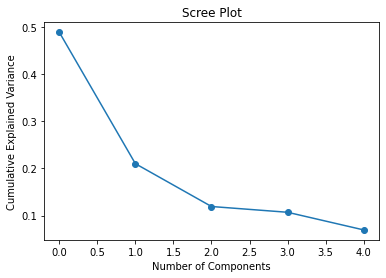

In [ ]:
from sklearn.decomposition import PCA
pca= PCA(n_components=5)
pca_fit=pca.fit(train_std)

#scree plot
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.plot(pca.explained_variance_ratio_,'o-')
pca.explained_variance_ratio_

In [ ]:
pip install factor_analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 507 kB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.4.0-py3-none-any.whl size=41455 sha256=64486c9b54cec635c6e22c7ba26e7bc528eb3fa90319c3b9cc4bf95e3b0a7fb2
  Stored in directory: /root/.cache/pip/wheels/ac/00/37/1f0e8a5039f9e9f207c4405bbce0796f07701eb377bfc6cc76
Successfully built factor-analyzer


                                0         1         2
Precipitation_accum     -0.010060  0.519560  0.076297
Humidity_avg             0.386386  0.341589  0.327462
Get_off_subway           0.278444 -0.225989 -0.199574
Fine_dust_concentration -0.041465 -0.374370  0.013678
L_Temperature            1.005071 -0.039572  0.197967
H_Temperature            0.946579  0.113656 -0.169869
A_Temperature            0.979081  0.057578 -0.015865


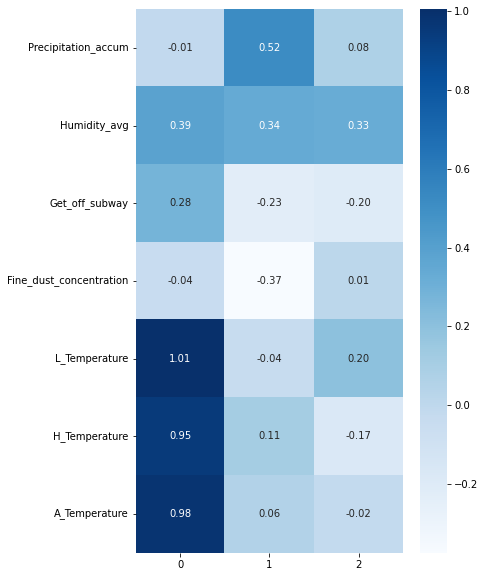

In [ ]:
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=3, method="ml", rotation="promax")
fa.fit(train_std)
print(pd.DataFrame(fa.loadings_, index=train_std.columns))
result=pd.DataFrame(fa.loadings_, index=train_std.columns)

plt.figure(figsize=(6,10))
sns.heatmap(result, cmap="Blues", annot=True, fmt='.2f')

<Figure size 2160x2160 with 0 Axes>

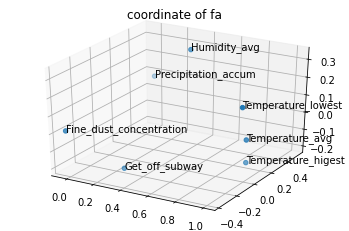

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(50, 40))
fig.set_size_inches(30, 30)
ax3d = plt.figure().gca(projection='3d')

arrayx = result[0].values
arrayy = result[1].values
arrayz = result[2].values

labels = ['Precipitation_accum', 'Humidity_avg', 'Get_off_subway',
       'Fine_dust_concentration','Temperature_lowest','Temperature_higest','Temperature_avg']

arrayx = arrayx.flatten()
arrayy = arrayy.flatten()
arrayz = arrayz.flatten()

ax3d.scatter(arrayx, arrayy, arrayz)

#give the labels to each point
for x_label, y_label, z_label, label in zip(arrayx, arrayy, arrayz, labels):
    ax3d.text(x_label, y_label, z_label, label)

plt.title("coordinate of fa")
plt.show()

# 전처리1

In [ ]:
#'강우여부' 파생변수 생성, 누적강수량 제거
all_data['Precipitation_accum'] = np.where(all_data['Precipitation_accum'] == 0, 0, 1)

#'평균기온', '최저기온','최고기온'을 '기온'으로 통일
all_data['Temperature'] = np.where(all_data['Season'] == 'Winter', all_data['L_Temperature'], np.where(all_data['Season'] == 'Summer', all_data['H_Temperature'], all_data['A_Temperature']))
all_data.drop(['L_Temperature', 'A_Temperature', 'H_Temperature'], axis = 1, inplace = True)

#데이터 타입 바꾸기
all_data = all_data.astype({'Year':'int'})
all_data = all_data.astype({'Month':'int'})
all_data = all_data.astype({'Date':'int'})
all_data = all_data.astype({'Fine_dust_concentration':'float64'})
all_data = all_data.astype({'Attendance':'float64'})         

#변수 정렬
all_data=all_data[ ['Year','Month','Date','Day','Season','Pub_holiday', 'Weekend','Vacation','Precipitation_accum','Humidity_avg','Attendance','Get_off_subway','Fine_dust_concentration',
                 'Temperature']]

#변수 영어로 바꾸기2
all_data = all_data.replace({'Day' : '월'},'Mon')
all_data = all_data.replace({'Day' : '화'},'Tue')
all_data = all_data.replace({'Day' : '수'},'Wed')
all_data = all_data.replace({'Day' : '목'},'Thu')
all_data = all_data.replace({'Day' : '금'},'Fri')
all_data = all_data.replace({'Day' : '토'},'Sat')
all_data = all_data.replace({'Day' : '일'},'Sun')

all_data = all_data.replace({'Season' : '봄'},'Spring')
all_data = all_data.replace({'Season' : '여름'},'Summer')
all_data = all_data.replace({'Season' : '가을'},'fall')
all_data = all_data.replace({'Season' : '겨울'},'Winter')     

1. 미세먼지 결측값-> 하차자수와 미세먼지 변수의 단일선형회귀로 얻은 예측값으로 대체

(이유: factor analysis 결과, 미세먼지와 하차자수 사이에 밀접한 관련이 있음을 확인)

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

X= all_data.dropna(axis=0)['Get_off_subway']
y= all_data.dropna(axis=0)['Fine_dust_concentration']


X=pd.DataFrame(X,index=X.index)
y=pd.DataFrame(y,index=y.index)

lin_reg_model = lin_reg.fit(X, y)
y_pred = lin_reg_model.predict(all_data.loc[:, ['Get_off_subway']])


all_data['Fine_dust_concentration'] = np.where(all_data['Fine_dust_concentration'].isnull(), 
                              pd.Series(y_pred.flatten()), 
                              all_data['Fine_dust_concentration'])

2. 원핫인코딩

In [ ]:
all_data_final=pd.get_dummies(all_data)

3. 분석에 필요없는 변수 지우기

In [ ]:
all_data_final.drop(columns=["Year", "Month","Date"],inplace=True)

4. y값 로그변환

In [ ]:
all_data_final['Attendance']=np.log1p(all_data_final['Attendance'])

시각화

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'After Logtransformation')

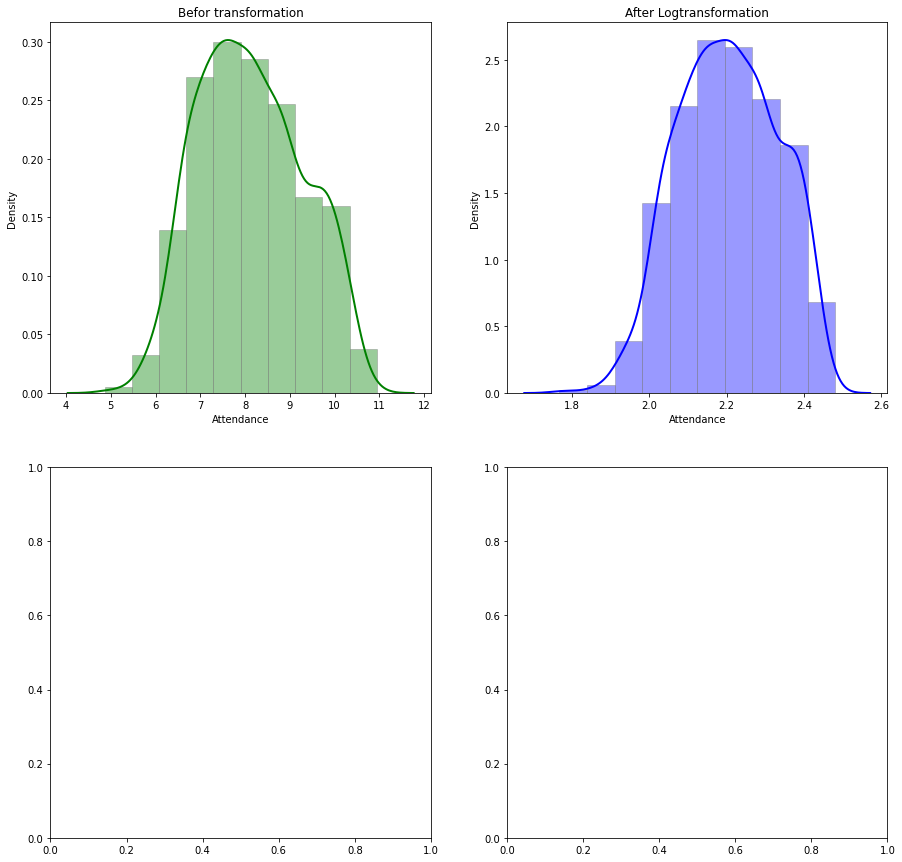

In [ ]:
fig, ax1 = plt.subplots(ncols=2, nrows=2, figsize=(15,15))

ax=sns.distplot(all_data_final['Attendance'], hist=True, kde=True, bins=10, color='green', hist_kws={'edgecolor': 'gray'}, kde_kws={'linewidth': 2},ax=ax1[0,0])
ax.set_title('Befor transformation')

ax=sns.distplot(np.log1p(all_data_final['Attendance']), hist=True, kde=True, bins=10, color='blue', hist_kws={'edgecolor': 'gray'}, kde_kws={'linewidth': 2},ax=ax1[0,1])
ax.set_title('After Logtransformation')

# train+test 다시 split

In [ ]:
train = all_data_final[:ntrain]
test = all_data_final[ntrain:]

test.reset_index(drop= True, inplace = True)

# 전처리2

표준화

In [ ]:
#train data 처리
train_num=train[['Humidity_avg','Get_off_subway','Fine_dust_concentration','Temperature']]
train_obj=train.drop(['Humidity_avg','Get_off_subway','Attendance','Fine_dust_concentration','Temperature'],axis=1)

#표준화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_num)
train_std = pd.DataFrame(scaler.transform(train_num), columns=train_num.columns, index=train_num.index) 

#최종 train_x와 train_y
train_final_x=pd.concat([train_std,train_obj],axis=1)
train_final_y=train['Attendance']

###########################################################################################################

#test data 처리
test_num=test[['Humidity_avg','Get_off_subway','Fine_dust_concentration','Temperature']]
test_obj=test.drop(['Humidity_avg','Get_off_subway','Attendance','Fine_dust_concentration','Temperature'],axis=1)

#표준화(test data에는 transform만 적용)
test_std = pd.DataFrame(scaler.transform(test_num), columns=test_num.columns, index=test_num.index) 

#최종 test_x와 test_y
test_final_x=pd.concat([test_std,test_obj],axis=1)
test_final_y=test['Attendance']

In [ ]:
test_final_x.columns

Index(['Humidity_avg', 'Get_off_subway', 'Fine_dust_concentration',
       'Temperature', 'Pub_holiday', 'Weekend', 'Vacation',
       'Precipitation_accum', 'Day_Fri', 'Day_Mon', 'Day_Sat', 'Day_Sun',
       'Day_Thu', 'Day_Tue', 'Day_Wed', 'Season_Spring', 'Season_Summer',
       'Season_Winter', 'Season_fall'],
      dtype='object')

#선형회귀 돌려보기

In [ ]:
train=pd.concat([train_final_x,train_final_y],axis=1)
from statsmodels.formula.api import ols
res=ols('Attendance ~Humidity_avg+ Get_off_subway+Fine_dust_concentration+Temperature+Pub_holiday+Weekend+Vacation+Precipitation_accum+Day_Fri+Day_Mon+Day_Sat+Day_Sun+Day_Thu+Day_Tue+Day_Wed+Season_Spring+Season_Summer+Season_Winter+Season_fall',data=train).fit()
res.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Attendance   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     198.9
Date:                Thu, 07 Jul 2022   Prob (F-statistic):          1.08e-293
Time:                        06:31:13   Log-Likelihood:                -858.42
No. Observations:                 994   AIC:                             1751.
Df Residuals:                     977   BIC:                             1834.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   5.7309      0.019    300.598      0.000       5.693       5.768
Humidity_avg               -0.0632      0.025     -2.525      0.012      -0.112      -0.014
Get_off_subway              0.6401      0.026     24.313      0.000       0.588       0.692
Fine_dust_concentration     0.0046      0.021      0.223      0.824      -0.036       0.045
Temperature                 0.3117      0.047      6.568      0.000       0.219       0.405
Pub_holiday                 0.5233      0.102      5.105      0.000       0.322       0.724
Weekend                     0.9877      0.027     36.820      0.000       0.935       1.040
Vacation                   -0.3774      0.057     -6.611      0.000      -0.489      -0.265
Precipitation_accum        -0.1703      0.046     -3.672      0.000      -0.261      -0.079
Day_Fri                     0.8465      0.044     19.062      0.000       0.759       0.934
Day_Mon                     1.0281      0.045     22.697      0.000       0.939       1.117
Day_Sat                     0.3386      0.039      8.753      0.000       0.263       0.415
Day_Sun                     0.6491      0.036     17.873      0.000       0.578       0.720
Day_Thu                     0.9834      0.044     22.281      0.000       0.897       1.070
Day_Tue                     0.9677      0.045     21.741      0.000       0.880       1.055
Day_Wed                     0.9174      0.044     20.745      0.000       0.831       1.004
Season_Spring               1.6926      0.039     43.738      0.000       1.617       1.769
Season_Summer               1.1650      0.066     17.655      0.000       1.036       1.295
Season_Winter               1.1513      0.073     15.823      0.000       1.008       1.294
Season_fall                 1.7220      0.033     51.658      0.000       1.657       1.787
==============================================================================
Omnibus:                       91.930   Durbin-Watson:                   1.330
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              307.992
Skew:                           0.414   Prob(JB):                     1.32e-67
Kurtosis:                       5.598   Cond. No.                     2.10e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.08e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# 모델링

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
!pip install catboost
import catboost as cb


def rmse_cv(model):
    rmse = -cross_val_score(model, train_final_x,train_final_y, scoring="neg_root_mean_squared_error", cv=5).mean()
    return rmse
def evaluation(y, predictions):
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


CB

In [ ]:
CB = cb.CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [30, 50, 100]
              }
grid_search = GridSearchCV(CB,parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

models=pd.DataFrame(columns=["Model","최적 모델의 cv_RMSE"])
new_row = {"Model": "CB","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
3:	learn: 1.1711221	total: 49.7ms	remaining: 572ms
4:	learn: 1.1642144	total: 53.4ms	remaining: 480ms
5:	learn: 1.1565381	total: 62.2ms	remaining: 456ms
6:	learn: 1.1486746	total: 83.2ms	remaining: 511ms
7:	learn: 1.1409993	total: 92ms	remaining: 483ms
8:	learn: 1.1335541	total: 103ms	remaining: 468ms
9:	learn: 1.1261032	total: 111ms	remaining: 443ms
10:	learn: 1.1191365	total: 115ms	remaining: 408ms
11:	learn: 1.1121681	total: 121ms	remaining: 382ms
12:	learn: 1.1053784	total: 124ms	remaining: 353ms
13:	learn: 1.0987585	total: 129ms	remaining: 331ms
14:	learn: 1.0916959	total: 138ms	remaining: 323ms
15:	learn: 1.0845434	total: 142ms	remaining: 302ms
16:	learn: 1.0773326	total: 150ms	remaining: 292ms
17:	learn: 1.0708203	total: 157ms	remaining: 279ms
18:	learn: 1.0640323	total: 178ms	remaining: 290ms
19:	learn: 1.0571240	total: 190ms	remaining: 285ms
20:	learn: 1.0508071	total: 218ms	remaining: 301ms
21:	learn: 1.0443540	total: 221ms	remaining: 281ms

,Model,최적 모델의 cv_RMSE
0,CB,0.45745


GB

In [ ]:

GBoost = GradientBoostingRegressor()
parameters = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": [0.01,0.05, 1]
}
grid_search = GridSearchCV(GBoost,parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

new_row = {"Model": "GB","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

최적의 하이퍼파라미터 {'learning_rate': 0.05, 'max_leaf_nodes': 20, 'n_estimators': 200}
최적 모델의 cv score 0.45963820919915654
최적 모델 GradientBoostingRegressor(learning_rate=0.05, max_leaf_nodes=20,
                          n_estimators=200)


,Model,최적 모델의 cv_RMSE
0,CB,0.465640
1,GB,0.459638


RF

In [ ]:
rf=RandomForestRegressor(random_state=42)
parameters ={'max_depth': [10, 50, 100],
     'max_features': [2,4,6,10,20],
     'n_estimators': [3,10,30,50]}
grid_search = GridSearchCV(rf,parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

new_row = {"Model": "Random forest","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

최적의 하이퍼파라미터 {'max_depth': 50, 'max_features': 10, 'n_estimators': 50}
최적 모델의 cv score 0.48718973316010034
최적 모델 RandomForestRegressor(max_depth=50, max_features=10, n_estimators=50,
                      random_state=42)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

,Model,최적 모델의 cv_RMSE
0,CB,0.465640
1,GB,0.459638
2,Random forest,0.487190


XGB

In [ ]:
XgbBoost=XGBRegressor(random_state=42)
parameters ={'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}
grid_search = GridSearchCV(XgbBoost ,parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

new_row = {"Model": "Xgboost","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

최적의 하이퍼파라미터 {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 500, 'nthread': 4, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.7}
최적 모델의 cv score 0.4565236399580666
최적 모델 XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=5,
             min_child_weight=4, n_estimators=500, nthread=4, random_state=42,
             silent=1, subsample=0.7)


,Model,최적 모델의 cv_RMSE
0,CB,0.465640
1,GB,0.459638
2,Random forest,0.487190
3,Xgboost,0.456524


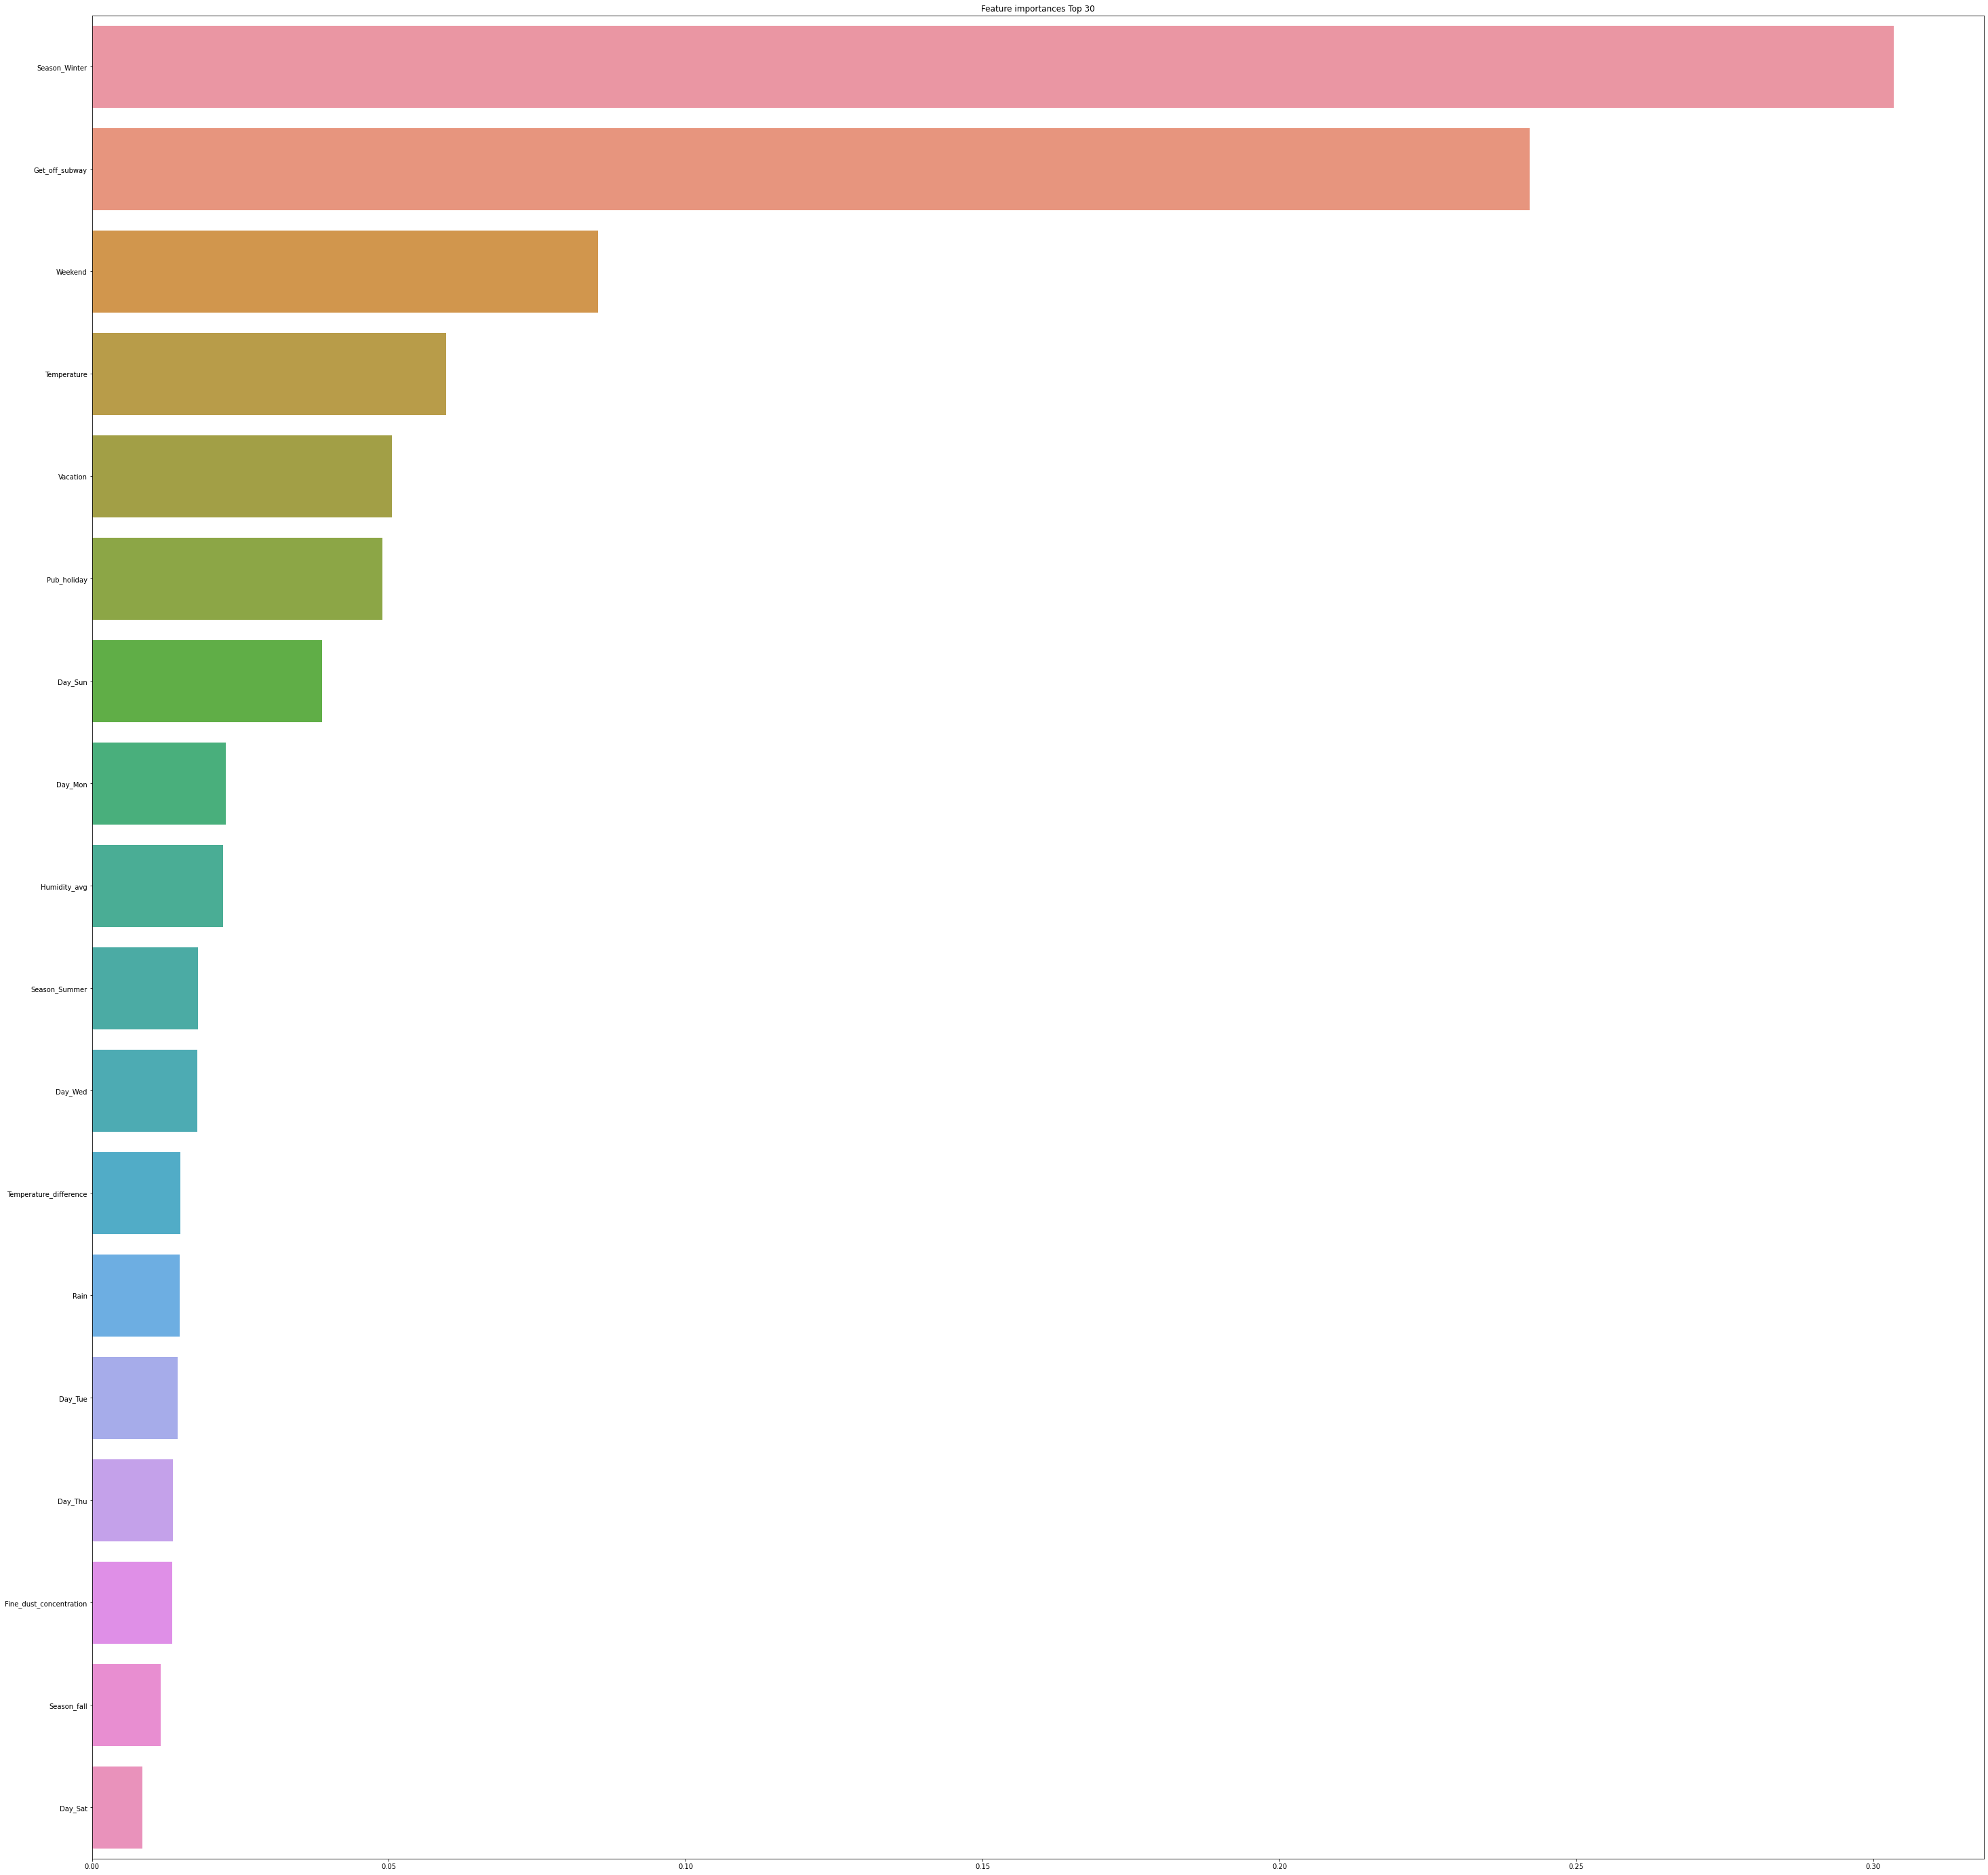

In [ ]:
importances_values =grid_search.best_estimator_.feature_importances_
importances = pd.Series(importances_values, index=train_final_x.columns)
top101 = importances.sort_values(ascending=False)[:30]
plt.figure(figsize=(50, 50))
plt.title('Feature importances Top 30')
sns.barplot(x = top101, y = top101.index)
plt.show()

In [ ]:
#a=list(importances[importances_values<0.01].index)
#train_final_x=train_final_x.drop(a,axis=1)
#test_final_x=test_final_x.drop(a,axis=1)

EXTRATREE

In [ ]:
Extree=ExtraTreesRegressor(random_state=42)
parameters={'max_depth': [10, 30, 100, 120],
     'max_features': [2,4,7,11,],
     'n_estimators': [3,15,30,55,80,100]}
grid_search = GridSearchCV(Extree ,parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

new_row = {"Model": "Extratree","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

최적의 하이퍼파라미터 {'max_depth': 30, 'max_features': 11, 'n_estimators': 55}
최적 모델의 cv score 0.4742390729927596
최적 모델 ExtraTreesRegressor(max_depth=30, max_features=11, n_estimators=55,
                    random_state=42)


,Model,최적 모델의 cv_RMSE
0,CB,0.465640
1,GB,0.459638
2,Random forest,0.487190
3,Xgboost,0.456524
4,Extratree,0.474239


LGBM

In [ ]:
Lgbm=LGBMRegressor(random_state=42)
parameters = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.1, 0.03, 0.003],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}
grid_search = GridSearchCV(Lgbm ,parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

new_row = {"Model": "LGBM","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

최적의 하이퍼파라미터 {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'num_leaves': 7}
최적 모델의 cv score 0.464428625287435
최적 모델 LGBMRegressor(max_depth=3, num_leaves=7, random_state=42)


,Model,최적 모델의 cv_RMSE
0,CB,0.465640
1,GB,0.459638
2,Random forest,0.487190
3,Xgboost,0.456524
4,Extratree,0.474239
5,LGBM,0.464429


Ada

In [ ]:
AdaBoost=AdaBoostRegressor(random_state=42)
parameters ={'n_estimators': [10,50,100,500] , 'learning_rate':[1,0.1,0.01,0.001,0.0001]}
grid_search = GridSearchCV(AdaBoost ,parameters, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

new_row = {"Model": "Adaboost","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

최적의 하이퍼파라미터 {'learning_rate': 0.001, 'n_estimators': 500}
최적 모델의 cv score 0.5861649266121762
최적 모델 AdaBoostRegressor(learning_rate=0.001, n_estimators=500, random_state=42)


,Model,최적 모델의 cv_RMSE
0,CB,0.465640
1,GB,0.459638
2,Random forest,0.487190
3,Xgboost,0.456524
4,Extratree,0.474239
5,LGBM,0.464429
6,Adaboost,0.586165


ELA

In [ ]:
Enet= ElasticNet(random_state=42)
parametersGrid = {"max_iter": [1, 5, 10],
                      "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}

grid_search = GridSearchCV(Enet ,parametersGrid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(train_final_x,train_final_y)
print('최적의 하이퍼파라미터',grid_search.best_params_)
print('최적 모델의 cv score', -grid_search.best_score_)
print('최적 모델',grid_search.best_estimator_ )

new_row = {"Model": "Enet","최적 모델의 cv_RMSE": -grid_search.best_score_}
models = models.append(new_row,ignore_index=True)
models

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.453e+02, tolerance: 1.122e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.602e+02, tolerance: 1.149e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented

최적의 하이퍼파라미터 {'alpha': 0.001, 'l1_ratio': 0.1, 'max_iter': 10}
최적 모델의 cv score 0.6046927454605436
최적 모델 ElasticNet(alpha=0.001, l1_ratio=0.1, max_iter=10, random_state=42)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.562e+02, tolerance: 1.393e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


,Model,최적 모델의 cv_RMSE
0,CB,0.465640
1,GB,0.459638
2,Random forest,0.487190
3,Xgboost,0.456524
4,Extratree,0.474239
5,LGBM,0.464429
6,Adaboost,0.586165
7,Enet,0.604693


Stacking

최종모델

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    #모델 복제 후 fitting 시킴
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 
        
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_final_x)
    rmse= np.sqrt(-cross_val_score(model, train_final_x, train_final_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)        

In [ ]:
CB =cb.CatBoostRegressor(depth= 6, iterations=100,learning_rate=0.1)
GB=GradientBoostingRegressor(learning_rate=0.05, max_leaf_nodes=50,
                          n_estimators=200)
XGB= XGBRegressor(colsample_bytree=0.7, learning_rate=0.03, max_depth=5,
             min_child_weight=4, n_estimators=500, nthread=4, random_state=42,
             silent=1, subsample=0.7)

LGB=LGBMRegressor(learning_rate=0.03, max_depth=5, n_estimators=500, num_leaves=7,
              random_state=42)

In [ ]:
#우영이형 전처리-> 그리드 서치 후 최적 파라미터 이용한 스태킹

averaged_models = AveragingModels(models = (XGB,CB))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(train_final_x,train_final_y)
test_pred= averaged_models.predict(test_final_x)

test_final_y1=np.expm1(test_final_y)
test_pred1=np.expm1(test_pred)

evaluation(test_final_y1,test_pred1)

0:	learn: 1.1137859	total: 1.53ms	remaining: 151ms
1:	learn: 1.0463552	total: 8.31ms	remaining: 407ms
2:	learn: 0.9815046	total: 10ms	remaining: 324ms
3:	learn: 0.9304922	total: 11.7ms	remaining: 281ms
4:	learn: 0.8785228	total: 13.4ms	remaining: 254ms
5:	learn: 0.8317260	total: 14.7ms	remaining: 231ms
6:	learn: 0.7917082	total: 16.4ms	remaining: 219ms
7:	learn: 0.7523165	total: 18.1ms	remaining: 208ms
8:	learn: 0.7202061	total: 19.7ms	remaining: 200ms
9:	learn: 0.6923622	total: 21.4ms	remaining: 192ms
10:	learn: 0.6651994	total: 23ms	remaining: 186ms
11:	learn: 0.6390332	total: 24.8ms	remaining: 182ms
12:	learn: 0.6180132	total: 26.5ms	remaining: 178ms
13:	learn: 0.5995942	total: 28.4ms	remaining: 175ms
14:	learn: 0.5808969	total: 30.1ms	remaining: 171ms
15:	learn: 0.5675517	total: 31.7ms	remaining: 167ms
16:	learn: 0.5530353	total: 33.4ms	remaining: 163ms
17:	learn: 0.5411181	total: 35ms	remaining: 160ms
18:	learn: 0.5300813	total: 36.7ms	remaining: 156ms
19:	learn: 0.5197716	total: 

2778.0743058412013

실제값 vs 예측값 시각화

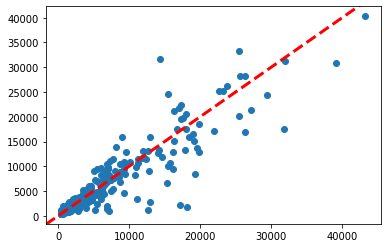

In [ ]:
plt.scatter(test_final_y1,test_pred1)
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='r', lw=3, scalex=False, scaley=False)

# 성능 개선 모델링

In [ ]:
!pip install optuna
!pip install catboost
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
import catboost as cb
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import PredefinedSplit
from sklearn import ensemble
import numpy as np
from sklearn.model_selection import KFold


def rmse_cv(model):
    rmse = -cross_val_score(model, train_final_x,train_final_y, scoring="neg_root_mean_squared_error", cv=5).mean()
    return rmse
def evaluation(y, predictions):
    rmse = np.sqrt(mean_squared_error(y, predictions))
    return rmse    

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 7.2 MB/s 
     |████████████████████████████████| 209 kB 52.9 MB/s 
     |████████████████████████████████| 81 kB 5.2 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 146 kB 44.5 MB/s 
     |████████████████████████████████| 112 kB 77.8 MB/s 
     |████████████████████████████████| 49 kB 7.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=5398d25c3f125721304c11e5823aea9c18ed47017e7ca57ab25b18d3627f8d00
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 94 kB/s 


In [ ]:
OPTUNA_EARLY_STOPING = 30

class EarlyStoppingExceeded(optuna.exceptions.OptunaError):
    early_stop = OPTUNA_EARLY_STOPING
    early_stop_count = 0
    best_score = None

def early_stopping_opt(study, trial):
    if EarlyStoppingExceeded.best_score == None:
      EarlyStoppingExceeded.best_score = study.best_value

    if study.best_value < EarlyStoppingExceeded.best_score:
        EarlyStoppingExceeded.best_score = study.best_value
        EarlyStoppingExceeded.early_stop_count = 0
    else:
      if EarlyStoppingExceeded.early_stop_count > EarlyStoppingExceeded.early_stop:
            EarlyStoppingExceeded.early_stop_count = 0
            best_score = None
            raise EarlyStoppingExceeded()
      else:
            EarlyStoppingExceeded.early_stop_count=EarlyStoppingExceeded.early_stop_count+1
    #print(f'EarlyStop counter: {EarlyStoppingExceeded.early_stop_count}, Best score: {study.best_value} and {EarlyStoppingExceeded.best_score}')
    return

GradientBoosting regressor

In [ ]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 1, 1000)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-8, 1e-2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 1000)
    n_estimators =  trial.suggest_int('n_estimators', 30, 1000)
    loss = trial.suggest_categorical('loss', ['ls'])

    
    regr = ensemble.GradientBoostingRegressor(max_depth = max_depth, learning_rate = learning_rate,
                                 min_samples_leaf = min_samples_leaf,n_estimators = n_estimators,loss=loss)
    score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
    neg_mean_squared_error_mean = score.mean()

    return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=500, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

[I 2022-07-07 06:34:35,908] A new study created in memory with name: no-name-d39a1bab-16a9-49aa-b4e0-b1828bbd81af
[I 2022-07-07 06:34:38,242] Trial 0 finished with value: -1.4041052547383992 and parameters: {'max_depth': 19, 'learning_rate': 1.595545481531233e-05, 'min_samples_leaf': 498, 'n_estimators': 565, 'loss': 'ls'}. Best is trial 0 with value: -1.4041052547383992.
[I 2022-07-07 06:34:42,468] Trial 1 finished with value: -1.3802937327339229 and parameters: {'max_depth': 251, 'learning_rate': 4.708307960501536e-05, 'min_samples_leaf': 157, 'n_estimators': 257, 'loss': 'ls'}. Best is trial 1 with value: -1.3802937327339229.
[I 2022-07-07 06:34:43,930] Trial 2 finished with value: -1.4041052547383992 and parameters: {'max_depth': 112, 'learning_rate': 0.0010583524610318668, 'min_samples_leaf': 514, 'n_estimators': 677, 'loss': 'ls'}. Best is trial 1 with value: -1.3802937327339229.
[I 2022-07-07 06:34:53,191] Trial 3 finished with value: -0.5450864765205582 and parameters: {'max_de

EarlyStopping Exceeded: No new best scores on iters 30


In [ ]:
Best_trial = study.best_trial.params
optimised_GB = ensemble.GradientBoostingRegressor(**Best_trial)
optimised_GB.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_GB.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

models=pd.DataFrame(columns=["Model","최적 모델의 cv_RMSE"])
new_row = {"Model": "GradientBoost","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

최적의 하이퍼파라미터 {'max_depth': 408, 'learning_rate': 0.005361406049178215, 'min_samples_leaf': 14, 'n_estimators': 993, 'loss': 'ls'}
최적 모델의 cv score 0.2145889538960696
최적 모델 FrozenTrial(number=12, values=[-0.21160521133159013], datetime_start=datetime.datetime(2022, 7, 7, 6, 35, 17, 593953), datetime_complete=datetime.datetime(2022, 7, 7, 6, 35, 50, 264756), params={'max_depth': 408, 'learning_rate': 0.005361406049178215, 'min_samples_leaf': 14, 'n_estimators': 993, 'loss': 'ls'}, distributions={'max_depth': IntUniformDistribution(high=1000, low=1, step=1), 'learning_rate': LogUniformDistribution(high=0.01, low=1e-08), 'min_samples_leaf': IntUniformDistribution(high=1000, low=1, step=1), 'n_estimators': IntUniformDistribution(high=1000, low=30, step=1), 'loss': CategoricalDistribution(choices=('ls',))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=12, state=TrialState.COMPLETE, value=None)


,Model,최적 모델의 cv_RMSE
0,GradientBoost,0.214589


CATboost

In [ ]:
def objective(trial):

    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 4000, 25000),
        'od_wait':trial.suggest_int('od_wait', 500, 2300),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.01, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',1e-5,100),
        'subsample': trial.suggest_uniform('subsample',0,1),
        'random_strength': trial.suggest_uniform('random_strength',10,50),
        'depth': trial.suggest_int('depth',1, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,30),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'colsample_bylevel':trial.suggest_float('colsample_bylevel', 0.4, 1.0),
    }

    # Generate model
    regr = cb.CatBoostRegressor(**cbrm_param)
    score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
    neg_mean_squared_error_mean = score.mean()

    return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=5, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

In [ ]:
Best_trial = study.best_trial.params
optimised_cb = cb.CatBoostRegressor(**Best_trial)
optimised_cb.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_cb.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

new_row = {"Model": "CatBoost","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

RF

In [ ]:
def objective(trial):
  rf_param = { 'max_features':trial.suggest_int('max_features', 1, 18),
              'max_depth':trial.suggest_int('max_depth', 10, 500),
              'n_estimators':trial.suggest_int('n_estimators', 1, 100) }

  regr = RandomForestRegressor(**rf_param)
  score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
  neg_mean_squared_error_mean = score.mean()

  return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=500, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

In [ ]:
Best_trial = study.best_trial.params
optimised_rf = RandomForestRegressor(**Best_trial)
optimised_rf.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_rf.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

new_row = {"Model": "RandomForest","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

XGB

In [ ]:
def objective(trial):

    xgb_param = {
        'objective':'reg:squarederror',
        'verbose': -1,
        'alpha': trial.suggest_uniform('alpha', 0.0, 1.0),
        'lambda': trial.suggest_uniform('lambda', 0.0, 10.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-2, 1e-1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }

    regr = XGBRegressor(**xgb_param)
    score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
    neg_mean_squared_error_mean = score.mean()

    return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=500, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

In [ ]:
Best_trial = study.best_trial.params
optimised_xgb = XGBRegressor(**Best_trial)
optimised_xgb.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_xgb.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

new_row = {"Model": "XGB","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

extratree

In [ ]:
def objective(trial):
  ex_param = { 'max_features':trial.suggest_int('max_features', 1, 18),
              'max_depth':trial.suggest_int('max_depth', 10, 500),
              'n_estimators':trial.suggest_int('n_estimators', 1, 100) }

  regr = ExtraTreesRegressor(**ex_param,random_state=42)
  score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
  neg_mean_squared_error_mean = score.mean()

  return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=1000)
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

In [ ]:
Best_trial = study.best_trial.params
optimised_rf = ExtraTreesRegressor(**Best_trial)
optimised_rf.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_rf.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

new_row = {"Model": "ExtraTrees","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

lgbm

In [ ]:
def objective(trial):

    lgbm_param = {
        'objective': 'regression',
        'verbose': -1,
        'metric': 'mse', 
        'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }
    regr = LGBMRegressor(**lgbm_param)
    score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
    neg_mean_squared_error_mean = score.mean()

    return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=500, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

In [ ]:
Best_trial = study.best_trial.params
optimised_lgbm = LGBMRegressor(**Best_trial)
optimised_lgbm.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_lgbm.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

new_row = {"Model": "lightgbm","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

ada

In [ ]:
def objective(trial):
    ada_param = { 'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
              'n_estimators':trial.suggest_int('n_estimators', 1, 100) }
    regr = AdaBoostRegressor(**ada_param,random_state=42)
    score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
    neg_mean_squared_error_mean = score.mean()

    return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective,n_trials=500, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

In [ ]:
Best_trial = study.best_trial.params
optimised_ada = AdaBoostRegressor(**Best_trial)
optimised_ada.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_ada.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

new_row = {"Model": "Adaboost","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

ela

In [ ]:
def objective(trial):
    ela_param = { 'max_iter':trial.suggest_int('max_iter', 1, 1000),
              'alpha':trial.suggest_uniform('alpha', 0.001, 1),
              'l1_ratio':trial.suggest_uniform('alpha', 0.001, 1) }
    regr = ElasticNet(**ela_param,random_state=42)
    score = cross_val_score(regr,train_final_x,train_final_y, cv=KFold(n_splits=10,shuffle=True,random_state=42), scoring="neg_mean_squared_error")
    neg_mean_squared_error_mean = score.mean()

    return neg_mean_squared_error_mean

In [ ]:
#Execute optuna and set hyperparameters
study = optuna.create_study(direction='maximize')
try:
    study.optimize(objective, n_trials=500, callbacks=[early_stopping_opt])
except EarlyStoppingExceeded:
    print(f'EarlyStopping Exceeded: No new best scores on iters {OPTUNA_EARLY_STOPING}')

In [ ]:
Best_trial = study.best_trial.params
optimised_ela = ElasticNet(**Best_trial)
optimised_ela.fit(train_final_x,train_final_y)
mse = mean_squared_error(train_final_y, optimised_ela.predict(train_final_x))

print('최적의 하이퍼파라미터',study.best_trial.params)
print('최적 모델의 cv score', np.sqrt(mse))
print('최적 모델',study.best_trial )

new_row = {"Model": "ElasticNet","최적 모델의 cv_RMSE": np.sqrt(mse)}
models = models.append(new_row,ignore_index=True)
models

stacking

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    #모델 복제 후 fitting 시킴
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 
        
#Validation function
n_folds = 10

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_final_x)
    rmse= np.sqrt(-cross_val_score(model, train_final_x, train_final_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)        

In [ ]:
gb_pr = {'max_depth': 11, 'learning_rate': 0.009794933198227902, 'min_samples_leaf': 23, 'n_estimators': 976, 'loss': 'ls'}
cb_pr = {'iterations': 10637, 'od_wait': 1789, 'learning_rate': 0.09404895730815328, 'reg_lambda': 51.08340432646926, 'subsample': 0.4808467400433857, 'random_strength': 21.485995983978867, 'depth': 7, 'min_data_in_leaf': 1, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.7489081189661576, 'colsample_bylevel': 0.4720188004073166}
rf_pr = {'max_features': 8, 'max_depth': 334, 'n_estimators': 47}
xgb_pr = {'alpha': 0.991686499088561, 'lambda': 9.088601450238277, 'colsample_bytree': 0.7444562628375917, 'subsample': 0.5647794393672237, 'learning_rate': 0.08133217592700553, 'n_estimators': 2994, 'max_depth': 15, 'min_child_weight': 1}
extra_pr = {'max_features': 15, 'max_depth': 101, 'n_estimators': 95}
extra_pr_best ={'max_features': 13, 'max_depth': 10, 'n_estimators': 77}
lgbm_pr = {'num_leaves': 365, 'colsample_bytree': 0.9102835616372518, 'reg_alpha': 0.043089329350601835, 'reg_lambda': 0.8937554642690848, 'max_depth': 12, 'learning_rate': 0.004536994407041464, 'n_estimators': 1035, 'min_child_samples': 10, 'subsample': 0.7982089163890633}
ada_pr = {'learning_rate': 0.0009024784370187951, 'n_estimators': 37}
ela_pr = {'max_iter': 989, 'alpha': 0.006310455718356221}

optimised_gb = ensemble.GradientBoostingRegressor(**gb_pr)
optimised_cb = cb.CatBoostRegressor(**cb_pr)
optimised_rf = RandomForestRegressor(**rf_pr)
optimised_xgb = XGBRegressor(**xgb_pr)
optimised_lgbm = LGBMRegressor(**lgbm_pr)
optimised_extra = ExtraTreesRegressor(**extra_pr)
optimised_extra_bs = ExtraTreesRegressor(**extra_pr_best)
optimised_ada = AdaBoostRegressor(**ada_pr)
optimised_ela = ElasticNet(**ela_pr)

In [ ]:
averaged_models = AveragingModels(models = (optimised_cb,optimised_rf))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(train_final_x,train_final_y)
test_pred= averaged_models.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1

evaluation(test_final_y1,test_pred1)

In [ ]:
averaged_models = AveragingModels(models = (optimised_cb,optimised_xgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(train_final_x,train_final_y)
test_pred= averaged_models.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1

evaluation(test_final_y1,test_pred1)

In [ ]:
averaged_models = AveragingModels(models = (optimised_extra,optimised_xgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(train_final_x,train_final_y)
test_pred= averaged_models.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1

evaluation(test_final_y1,test_pred1)

In [ ]:
averaged_models = AveragingModels(models = (optimised_extra,optimised_xgb,optimised_rf))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(train_final_x,train_final_y)
test_pred= averaged_models.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1

evaluation(test_final_y1,test_pred1)

In [ ]:
averaged_models = AveragingModels(models = (optimised_cb,optimised_xgb,optimised_extra))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

averaged_models.fit(train_final_x,train_final_y)
test_pred= averaged_models.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1

evaluation(test_final_y1,test_pred1)

단일모델

In [ ]:
optimised_extra.fit(train_final_x,train_final_y)
test_pred= optimised_extra.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_xgb.fit(train_final_x,train_final_y)
test_pred= optimised_xgb.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_rf.fit(train_final_x,train_final_y)
test_pred= optimised_rf.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_ela.fit(train_final_x,train_final_y)
test_pred= optimised_ela.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_cb.fit(train_final_x,train_final_y)
test_pred= optimised_cb.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_gb.fit(train_final_x,train_final_y)
test_pred= optimised_gb.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_ada.fit(train_final_x,train_final_y)
test_pred= optimised_ada.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_lgbm.fit(train_final_x,train_final_y)
test_pred= optimised_lgbm.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

In [ ]:
optimised_extra_bs.fit(train_final_x,train_final_y)
test_pred= optimised_extra_bs.predict(test_final_x)

test_final_y1=np.exp(test_final_y)-1
test_pred1=np.exp(test_pred)-1
evaluation(test_final_y1,test_pred1)

# 예측

In [ ]:
test_final_x.columns

In [ ]:
날짜 : 2022-07-09
요일 : 토
계절 : 여름
공휴일여부 : 0
쉬는날여부 : 0
방학여부 : 1
강수여부 : 0
평균 습도 : 83.54
대공원역 하차자 수 : 4237 (3개년 7월 평균)
미세먼지 :  30 (좋음의 최고치)
최고기온 : 32

In [ ]:
tomorrow_data = pd.DataFrame({'Humidity_avg' :[83.54], 'Get_off_subway':[4237], 'Fine_dust_concentration':[30],
       'Temperature':[32], 'Pub_holiday':[0], 'Weekend':[0], 'Vacation':[1],
       'Precipitation_accum':[0], 'Day_Fri':[0], 'Day_Mon':[0], 'Day_Sat':[1], 'Day_Sun':[0],
       'Day_Thu':[0], 'Day_Tue':[0], 'Day_Wed':[0], 'Season_Spring':[0], 'Season_Summer':[1],
       'Season_Winter':[0], 'Season_fall':[0]})

In [ ]:
final_pred = optimised_extra_bs.predict(tomorrow_data)
np.exp(final_pred)-1